# Species Bags in Species-collectors Networks
#### Author: Pedro Correia de Siracusa
#### Date:  Nov 15 2017

---

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

## Preparing Data

### Loading the UB Herbarium dataset

In [2]:
dsetPath = '/home/pedro/datasets/ub_herbarium/occurrence.txt'

In [3]:
cols = ['recordedBy', 'scientificName', 'family', 'genus', 'species','taxonRank', 
        'stateProvince', 'locality', 'municipality', 'occurrenceRemarks',
        'eventDate', 'identifiedBy']

occs = pd.read_table(dsetPath, delimiter='\t', usecols=cols, low_memory=False)

I'll only use data with taxonomic resolution of species

In [4]:
occs.dropna(subset=['recordedBy','scientificName'], inplace=True)
occs = occs[occs['taxonRank']=='SPECIES']

In [5]:
occs.head()

,recordedBy,occurrenceRemarks,eventDate,stateProvince,municipality,locality,identifiedBy,scientificName,family,genus,taxonRank,species
0,"Irwin, HS","Ascending subshrub 0,3m. Fruit gray-green; Cer...",1972-01-16T01:00Z,Goiás,NaN,"Serra dos Pireneus, ca. 20km E of Pirenópolis",NaN,Annona monticola Mart.,Annonaceae,Annona,SPECIES,Annona monticola
1,"Ratter, JA; et al.",Coppice branches sprouting from the stump of a...,1976-06-30T01:00Z,Minas Gerais,NaN,"Near Pandeiros, ca. 30.0 km W of Januária",Flora do Brasil,Myracrodruon urundeuva Allem.,Anacardiaceae,Myracrodruon,SPECIES,Myracrodruon urundeuva
2,"Heringer, EP",NaN,1954-06-05T01:00Z,Minas Gerais,NaN,Fazenda do Rasgão. Terreno de cultura,Flora do Brasil,Myracrodruon urundeuva Allem.,Anacardiaceae,Myracrodruon,SPECIES,Myracrodruon urundeuva
3,"Coelho, JP","Pouco frequente, sem folhas nesse período; Árv...",1964-10-15T01:00Z,Minas Gerais,NaN,IPEACO- Sete lagoas,Flora do Brasil,Myracrodruon urundeuva Allem.,Anacardiaceae,Myracrodruon,SPECIES,Myracrodruon urundeuva
4,"Eiten, G; Eiten, LT","Tree 5.0 m. tall, 11.0 cm d.b.h. With young fr...",1963-08-17T01:00Z,Maranhão,Loreto,"Ilha de Balsas region, between the Balsas and ...",Flora do Brasil,Myracrodruon urundeuva Allem.,Anacardiaceae,Myracrodruon,SPECIES,Myracrodruon urundeuva


In [6]:
occs['taxonRank'].value_counts()

SPECIES    140763
Name: taxonRank, dtype: int64

In [7]:
"Total num of records: "+str(occs.shape[0])

'Total num of records: 140763'

### Loading previously cleaned collectors identities

In [8]:
from modules.cleaning.names import read_NamesMap_fromJson, NamesAtomizer, namesFromString

# read a names map
nm = read_NamesMap_fromJson('./ub_names_map_2.json')

# atomizing names
atomizingOp = lambda x: namesFromString(x)
na = NamesAtomizer(atomizingOp)

occs['recordedBy_atomized'] = na.atomize(occs['recordedBy'])

# build names index
from modules.cleaning.names import getNamesIndexes

ni = getNamesIndexes(occs,'recordedBy_atomized',nm.getMap())

/home/pedro/datascience_biodiversity/notebooks/modules/cleaning/names.py:536: UserWarning: A names map was created without a normalization function!
  warn("A names map was created without a normalization function!")


---

## Building the SCN Network model

In [9]:
from modules.models.networks import SpeciesCollectorsNetwork

In [10]:
scn = SpeciesCollectorsNetwork(species=occs['scientificName'],
                               collectorsNames=occs['recordedBy_atomized'],
                               namesMap=nm,
                               weighted=True)

First we want to filter some nodes out of the network

In [11]:
nodesToRemove = ['etal','','incognito']
scn.remove_nodes_from(nodesToRemove)

And then add some attributes

In [12]:
# degree
nx.set_node_attributes(scn,'degree',nx.degree(scn))

# weighted degree
nx.set_node_attributes(scn,'degree_weighted',nx.degree(scn,weight='weight'))

# set species families
sp_families = occs[['scientificName','family']].drop_duplicates()
sp_families_dict = dict(zip(sp_families['scientificName'],sp_families['family']))
nx.set_node_attributes(scn, 'family', sp_families_dict)

### Grouping an SCN by a taxonomic attribute

Here I use the taxonomic attribute 'family' for grouping SCN nodes.

In [13]:
from collections import Counter

def aggregateByTaxLevel(network, level):
    spNodes = network.getSpeciesNodes(data=True)
    taxonMap = dict( (sp,d[level]) for sp,d in spNodes )
    taxGroupsNames = list(set(taxonMap.values()))

    edgesList = [ (taxonMap[u],v,d) for u,v,d in network.edges((n for n,d in spNodes), data=True) ]
    edges = Counter( (u,v) for u,v,d in edgesList for i in range(d['weight']) )

    net_aggr = SpeciesCollectorsNetwork()
    net_aggr.add_nodes_from(network.getCollectorsNodes(),bipartite=0)
    net_aggr.add_nodes_from(taxGroupsNames, bipartite=1)
    net_aggr.add_edges_from( (u,v,{'weight':w}) for (u,v),w in edges.items() )
    
    return net_aggr

In [14]:
scn_family = aggregateByTaxLevel(scn,'family')

nodesToRemove = ['etal','','incognito',np.nan]
scn_family.remove_nodes_from(nodesToRemove)

In [15]:
# degree
nx.set_node_attributes(scn_family,'degree',nx.degree(scn_family))

# weighted degree
nx.set_node_attributes(scn_family,'degree_weighted',nx.degree(scn_family,weight='weight'))

---

## Species Bags

In a SCN model each collector is linked to a set of species she has ever collected, and conversely each species is linked to the set of collectors that have ever recorded it. I define a collector's **species bag** as an array of counts of species in her collections history. Formally a species bag $ \sigma$ of a collector $\mu$ is represented as a vector

$$ 
\sigma^{(\mu)} =  \begin{bmatrix}
\sigma_1^{(\mu)}, \sigma_2^{(\mu)}, \cdots, \sigma_n^{(\mu)}
\end{bmatrix}  \quad : \quad 
n = |S_{sp}|
$$

where $n$ is the length of the species set $S_{sp}$ and $\sigma^{(\mu)}_i$ is the total number of records of species $i$ by collector $\mu$.

The species bag for a collector can be calculated by using the `getSpeciesBag` method from the `SpeciesCollectorsNetwork` class. It returns a tuple containing an index with the species names and a *Scipy* sparse matrix containing the species bag vector itself. The order in which species names are placed in the index is the same as in the vector. To give an example let's retrieve the species bag from 'Munhoz,C.B.R.'.

In [16]:
i,m = scn.getSpeciesBag('munhoz,cbr')

We can unpack an ordered list with species counts by zipping both the index and the vector. I'll only retrieve the top-20 species.

In [17]:
sorted( list(zip( i, np.array(m.todense()).flatten() )), key=lambda x: x[1], reverse=True )[:20]

[('Syngonanthus nitens (Bong.) Ruhland', 30),
 ('Rhynchospora globosa (Kunth) Roem. & Schult.', 25),
 ('Xyris hymenachne Mart.', 23),
 ('Axonopus brasiliensis (Spreng.) Kuhlm.', 21),
 ('Trachypogon spicatus (L.f.) Kuntze', 20),
 ('Comanthera xeranthemoides (Bong.) L.R.Parra & Giul.', 19),
 ('Rhynchospora consanguinea (Kunth) Boeckeler', 19),
 ('Paepalanthus elongatus (Bong.) Körn.', 18),
 ('Xyris savanensis Miq.', 18),
 ('Curtia tenuifolia (Aubl.) Knobl.', 17),
 ('Lagenocarpus rigidus (Kunth) Nees', 17),
 ('Andropogon virgatus Desv. ex Ham.', 16),
 ('Hyptis linarioides Pohl ex Benth.', 16),
 ('Xyris schizachne Mart.', 16),
 ('Rhynchospora emaciata (Nees) Boeckeler', 15),
 ('Syngonanthus gracilis (Bong.) Ruhland', 15),
 ('Paspalum hyalinum Nees ex Trin.', 14),
 ('Trimezia juncifolia Klatt', 14),
 ('Chamaecrista desvauxii (Collad.) Killip', 13),
 ('Rhynchanthera grandiflora (Aubl.) DC.', 13)]

### Species Bags Similarity

We might want to compare collectors in terms of their species bags. We calculate the **Species Bag Similarity** between collectors $\mu_i$ and $\mu_j$ by computing the *Cosine Similarity* of their species bags vectors:

$$
sim(\sigma^{(\mu_i)},\sigma^{(\mu_j)}) =
\cos \theta_{\mu_i,\mu_j} \equiv
\frac{  \sigma^{(\mu_i)} \cdot \sigma^{(\mu_j)}  }{  ||\sigma^{(\mu_i)}||_2  ||\sigma^{(\mu_j)}||_2  }
$$

where the output ranges from [0,1].

The function below calculates species bags similarity. It takes two optional collectors names in `col1` and `col2` parameters, and output type varies depending on how many collectors names are given.

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
import scipy

def calculateSimilarity( G, col1=None, col2=None ):
    """
    Returns
    -------
    If neither col1 and col2 are informed, a tuple ( colsList, csr_sparse_similarityMatrix )
    If only col1 is informed, a tuple ( colsList, similarityVector )
    If col1 and col2 are informed, a tuple ( [col1,col2], similarity )
    """
    if G._speciesBag_matrix is None:
        G._buildSpeciesBagMatrix()
    
    colList, spList, m = G._speciesBag_matrix
    
    if col1 is not None:
        if col2 is not None:
            sim = cosine_similarity( scn.getSpeciesBag(col1)[1], scn.getSpeciesBag(col2)[1] )[0][0] 
            return ([col1,col2], sim)
        else:
            simVector = cosine_similarity( scn.getSpeciesBag(col1)[1], m )
            return ( colList, scipy.sparse.csr_matrix(simVector) )
        
    else:
        return( colList, scipy.sparse.csr_matrix(cosine_similarity(m)) )

First, if we wanted to simply retrieve the entire species bags similarity matrix we can simply call this function without passing collectors names. Note that all elements in the diagonal of the similarity matrix are ones.

In [19]:
i,m = calculateSimilarity(scn)

In [20]:
i[:10]

['abbas,b',
 'abdala,gc',
 'abdo,msa',
 'abdon',
 'abe,lm',
 'abrahim,ma',
 'abreu,gx',
 'abreu,i',
 'abreu,lcr',
 'abreu,mc']

In [21]:
m.todense() # m is a csr sparse matrix

matrix([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

We can also calculate a similarity vector for a given collector, which holds her similarity with all other collectors, including itself. Let's compute, for example, the similarity vector for 'munhoz,cbr'.

In [22]:
i,m = calculateSimilarity(scn,'munhoz,cbr')

In [23]:
m.todense()

matrix([[ 0.00730726,  0.        ,  0.00353577, ...,  0.        ,
          0.        ,  0.        ]])

Who are the top-10 collectors most similar to Munhoz,CBR?

In [24]:
sorted( list(zip(i, np.array(m.todense()).flatten())), key=lambda x:x[1], reverse=True)[:10]

[('munhoz,cbr', 0.99999999999999267),
 ('amaral,ag', 0.75137262358463819),
 ('eugenio,cuo', 0.72327560020983406),
 ('emmert,p', 0.71216702601217519),
 ('mello,trb', 0.69920571204778381),
 ('chagas,ur', 0.65072933682219702),
 ('silva,dp', 0.65038200328433593),
 ('cristine,a', 0.58353717801179739),
 ('correa,acg', 0.57466387100179006),
 ('bijos,nr', 0.56124589372476164)]

Last we can also compute the similarity for a pair of collectors:

In [25]:
i,score = calculateSimilarity(scn,'munhoz,cbr','proenca,ceb')
"Similarity score between {} and {}: {}".format(*i,score)

'Similarity score between munhoz,cbr and proenca,ceb: 0.32207714985042757'

### Filtering values from a similarity matrix

It is useful to keep a record only of the most significant similarities in the matrix. We can define a threshold and filter out all of these element below it. I'll exemplify using rows 0 to 10 and columns 164 to 173.

In [26]:
from copy import deepcopy

def filterMatrix(m, thresh):
    m_filtered = deepcopy(m)
    m_filtered.data = np.where(m_filtered.data >= thresh, m_filtered.data, 0)
    m_filtered.eliminate_zeros()
    return m_filtered

In [27]:
i,m = calculateSimilarity(scn)

In [28]:
m[0:10,164:174].todense()

matrix([[ 0.        ,  0.03328406,  0.        ,  0.        ,  0.        ,
          0.        ,  0.09622504,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.00784513,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.00286314,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.01921656,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.19245009,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.       

Now, let's filter it with a threshold of 0.05

In [29]:
m_filtered = filterMatrix(m,0.05)

In [30]:
m_filtered[0:10,164:174].todense()

matrix([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.09622504,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.19245009,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.       

### Creating a projected SCN Network from the similarity matrix

The similarity matrix can be used to build a similarity graph. The similarity graph is a type of SCN projection on the collectors set. In order not to add self-loops, I will set all diagonal elements of the similarity matrix to zero.

In [31]:
collNames,m = calculateSimilarity(scn)
m.setdiag(0)

m = filterMatrix(m,thresh=3)

In [32]:
G = nx.from_scipy_sparse_matrix(m)

In [33]:
# relabel nodes
namesMap = dict( (i,n) for i,n in enumerate(collNames) )
G = nx.relabel_nodes(G,namesMap)

Let's now copy the attributes from the SCN to the similarity graph

In [34]:
# degree
deg_dict = dict((n,d['degree']) for n,d in scn.getCollectorsNodes(data=True))
nx.set_node_attributes(G, 'degree', deg_dict)

# weighted degree
degw_dict = dict((n,d['degree_weighted']) for n,d in scn.getCollectorsNodes(data=True))
nx.set_node_attributes(G, 'degree_weighted', degw_dict)

In [35]:
nx.write_gexf(G,'./graph_similarity.gexf')

---

### Threshold value and Similarity Matrix sparsity

The **sparsity** measure $\sigma$ for a sparse matrix is defined as the proportion of zero-valued elements in the matrix. Sparsity is strongly related to the sparse matrix **density** $\rho$, and can be alternatively derived from the relation $\sigma = 1 - \rho$.

The density measure $\rho$ can be obtained from

$$\rho = \frac{N^+}{(m\times n)}$$

where $N^+$ is the number of non-zero-valued elements in the sparse matrix; and $m$ and $n$ are, respectively, the number of rows and columns.

Now let's check how filtering the similarity matrix with increasing threshold values affect its sparsity. As similarity matrices of SCN networks can be densely connected, we would ideally only keep the most relevant associations by setting a good threshold value. One idea for finding such value is by inspecting the effect of threshold in matrix sparsity (or density). We want to find a point where increasing the threshold doesn't affect the rate at which matrix density decreases.

In [36]:
calculateDensity = lambda m: len(m.data)/np.prod(m.shape)

In [37]:
m_scn = calculateSimilarity(scn)[1]
m_scn_family = calculateSimilarity(scn_family)[1]

X = np.logspace(-3,0)
y_scn = np.array( [calculateDensity(filterMatrix(m_scn,thresh)) for thresh in X] )
y_scn_family = np.array( [calculateDensity(filterMatrix(m_scn_family,thresh)) for thresh in X] )

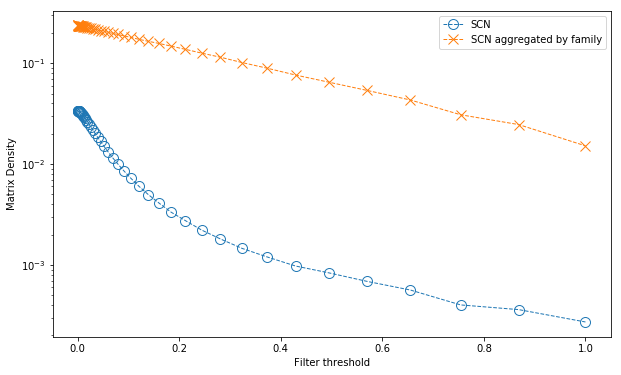

In [38]:
plt.figure(figsize=(10,6))
plt.plot(X, y_scn, 'o', ls='--', markerfacecolor='none', label='SCN', markersize=10,lw=1)
plt.plot(X,y_scn_family, 'x', ls='--', markerfacecolor='none', label='SCN aggregated by family',markersize=10,lw=1)
plt.yscale('log')

plt.legend()
plt.xlabel('Filter threshold')
plt.ylabel('Matrix Density')

**Figure.** Effects of increasing filter threshold for the similarity matrices of both the original SCN and the SCN with nodes taxonomically aggregated by family.

As shown in the figure above, the SCN aggregated by family fits well to an exponential model $y=\alpha e^{-x}$. Its similarity matrix density exponentially decreases when increasing the filter threshold. The decrease pattern of the original SCN similarity matrix, however, is not strictly exponential. The plot shows a steep decay in matrix density from threshold values ranging from 0 to 0.2, followed by a stabilization in the density exponential decreasing rate for threshold values ranging from approximately 0.4 to 1. Therefore a filter value of approximately 0.4 seems to be a good starting point.

In [39]:
# TODO
# Check real metric for matrix sparsity
# Who is most likely to have collected species x? <- random walks?

---